# Collaboration and Competition

---

This notebook contains the solution implemented for the "Collaboration and Competition" project based on a Unity's ML-Agents environment. This is the third and last project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. Solution description

The project consist of the resolution of a multi-agent environment (two) where the Multi-Agent Deep Deterministic Policy Gradients (MADDPG) algorithm was used to solve the scenario.

The MADDPG algorithm uses an actor-critic approach with centralized planning and decentralized execution. In can be used for competitive, cooperative and mixed scenarios.

<p align="middle"><img src="images\Centralized planning-decentralized execution.png" width="600"></p>

When training the critic part of the agents uses the states observed by all the agents as input (and their actions).

<p align="middle"><img src="images\training.png" width="600"></p>

During testing the actors only have access to their own observations to take actions.

<p align="middle"><img src="images\execution.png" width="600"></p>

For the code the algorithm shown in the Lesson 6 (Deep RL for Finance) has been used as reference and adapted to the MADDPG specifications. The networks and the hyperparameters have been defined from scratch and have been tuned from testing.

Once the agent reach the specified goal (the average over 100 episodes of the higher score for both agents is at least +0.5), the networks for both agents are saved (with their actor and critic models) in the "final" directory and a graph with the scores and the running means (for a window of 100 episodes) is plotted.

As indicated above, the "final" directory contains the weights of the final networks while the intermediate weights obtained during training are in the "checkpoints" directory.

The project solution is comprised of this same jupyter notebook (Tennis.ipynb) and the following files:

* maddpg_manager.py: Contains the "manager" class to manage the whole training process, here are instantiated the needed agents.
* maddpg_agent.py: Contains the agent implementation for the MADDPG algorithm.
* maddpg_model.py: Contains the definition of the networks for the actor and the critic.
* maddpg_replaybuffer.py: Contains the implementation of the replay buffer.
* utils.py: Contains utility functions.

## 2. Training phase

### 1. Importing the required packages

We begin by importing some necessary packages. maddpg_agent and utils are modules developed as part of the solution.

In [1]:
import numpy as np
import torch
from collections import deque
from maddpg_manager import MADDPGManager
from utils import plot_scores
%matplotlib inline

### 2. Setting the model and training parameters 

Next, a series of constants are defined that will allow the model to be parameterized centrally throughout the project. This avoids having to go through different files to configure the parameters and avoids errors in the training phase.

In [2]:
# Training parameters
TRAINING_MODE = False                            # Enable or disable the graphical output
N_EPISODES = 10000                              # Max number of episodes for the training
MAX_T = 500                                    # Max number of steps per episode
SCORES_WINDOW = 100                             # Size for the window of the average score
GOAL_SCORE = 0.5                                # Target average score over 100 consecutive episodes

# Environment parameters
NUM_AGENTS = 2                                  # Number of agents playing
STATE_SIZE = 24                                 # Size for three stacked observations per agent (8*3=24)
ACTION_SIZE = 2                                 # Size for the action
# CRITIC_STATE_SIZE = NUM_AGENTS * (AGENT_STATE_SIZE + ACTION_SIZE)       # Size for the critic input (2*(24+2))
RANDOM_SEED = 777                              # Random seed
UNITY_ENV_PATH = 'Tennis_Windows_x86_64\Tennis.exe'         #Path for the Unity environment

# Agent parameters
BUFFER_SIZE = 100000                            # Size for the replay memory
BATCH_SIZE = 256                                # Size for the minibatch
GAMMA = 0.99                                       # According to the specification where won't be discount for the rewards
TAU = 1e-3                                      # Parameter for soft update of Q_target 
# TAU = 0.002                                      # Parameter for soft update of Q_target 
# LR_ACTOR = 1e-4                               # Learning rate of the actor 
# LR_CRITIC = 1e-3                              # Learning rate of the critic
LR_ACTOR = 1e-4                              # Learning rate of the actor 
LR_CRITIC = 1e-3                              # Learning rate of the critic
UPDATE_FRECUENCY = 2
# WEIGHT_DECAY = 1e-4                           # L2 weight decay
WEIGHT_DECAY = 0.0                                # L2 weight decay

# Network parameters
HIDDEN_LAYERS = (256, 256)                       # Tuple with the sizes for the hidden layers (generated dynamically from these values)

# Checkpoints parameters
CHECKPOINTS_PATH = "checkpoints"                # Directory for the checkpoints of the network weights

### 3. Configuring where the model will run
GPU processing is configured whenever possible, a message indicates whether the model will be trained/executed on the CPU or on the GPU using CUDA.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 4. Starting up the environment

The environment is started.  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

If TRAINING_MODE is True there won't be graphical output of the environment during training to speed up the process.

In [4]:
from unityagents import UnityEnvironment
if TRAINING_MODE:
    env = UnityEnvironment(file_name = UNITY_ENV_PATH, no_graphics=True)
else:
    env = UnityEnvironment(file_name = UNITY_ENV_PATH)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

print (f"Vector action description: {brain.vector_action_descriptions}")

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
Vector action description: ['', '']
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 7. Training the model

In the next code cell we are going to train the agent in the running environment.

Here the agent will run several episodes (with the maximum specified) each one with a maximum of 1000 timesteps.

Once the goal is achieved the training stops and the weights for the actor and the critic networks will be saved.

After this, a graph with the increasing score along the episodes will be plotted with the moving averages for 100 episodes.

Episode 100	Average Score: 0.009	 Max Score: 0.100
Episode 200	Average Score: 0.009	 Max Score: 0.100
Episode 300	Average Score: 0.026	 Max Score: 0.100
Episode 400	Average Score: 0.010	 Max Score: 0.100
Episode 500	Average Score: 0.027	 Max Score: 0.190
Episode 600	Average Score: 0.027	 Max Score: 0.100
Episode 700	Average Score: 0.007	 Max Score: 0.100
Episode 800	Average Score: 0.005	 Max Score: 0.100
Episode 900	Average Score: 0.036	 Max Score: 0.300
Episode 1000	Average Score: 0.051	 Max Score: 0.190
Episode 1100	Average Score: 0.045	 Max Score: 0.200
Episode 1200	Average Score: 0.062	 Max Score: 0.200
Episode 1300	Average Score: 0.094	 Max Score: 0.300
Episode 1400	Average Score: 0.119	 Max Score: 0.400
Episode 1500	Average Score: 0.139	 Max Score: 0.690
Episode 1600	Average Score: 0.406	 Max Score: 1.400
 Environment Solved in Episode 1627	Average Score: 0.508


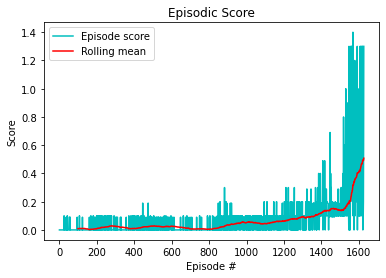

In [6]:
def maddpg(n_episodes, max_t):
          
    # All the agents will have the same action space
    maddpg_manager = MADDPGManager(num_agents=NUM_AGENTS, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_layers=HIDDEN_LAYERS, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, update_frequency=UPDATE_FRECUENCY, gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, random_seed=RANDOM_SEED)     
    
    scores_deque = deque(maxlen=SCORES_WINDOW)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  
        states = env_info.vector_observations                  # get the current observations (here are the states for all the agents) 
        
        scorestab = np.zeros(num_agents)                   # initialize the score (for each agent)
        rewardslist = []   

        for t in range(max_t):
            
            actions = maddpg_manager.act(states)      # get the actions from all the agents
                    
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    
            next_states = env_info.vector_observations         # get next state (for each agent)            
            rewards = env_info.rewards                         # get reward (for each agent)                       
            dones = env_info.local_done                        # see if episode finished                                                    
                       
            maddpg_manager.save_experience(states, actions, rewards, next_states, dones)
            
            scorestab += env_info.rewards            
            rewardslist.append(rewards)
            
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if episode finished
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(rewardslist),axis=0))        
        scores.append(episode_reward)             # save most recent score to overall score array
        scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
        
        # log average score every 100 episodes        
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.3f}\t Max Score: {np.max(scores_deque):.3f}")
            
        if i_episode % 1000 == 0:            
            maddpg_manager.save_checkpoint(path=CHECKPOINTS_PATH, is_final=False)
            
        if np.mean(scores_deque) >= 0.5:        # The problem is considered solved when the average over 100 episodes of the scores is at least +0.5
            print(f"\r Environment Solved in Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.3f}")
            maddpg_manager.save_checkpoint(path=CHECKPOINTS_PATH, is_final=True)
            break
    return scores

scores = maddpg(n_episodes=N_EPISODES, max_t=MAX_T)

plot_scores(scores)

## 3. Validation phase

The trained model will then be loaded and its performance in the Unity environment will be shown:

In [6]:
import os

maddpg_manager = MADDPGManager(num_agents=NUM_AGENTS, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_layers=HIDDEN_LAYERS, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, update_frequency=UPDATE_FRECUENCY, gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, random_seed=RANDOM_SEED)       

maddpg_manager.load_checkpoint(os.path.join(CHECKPOINTS_PATH,"final"), "1654785585.pth")

for agent in maddpg_manager.agents:   
    agent.actor_local.to(device)
    agent.critic_local.to(device)

env_info = env.reset(train_mode=False)[brain_name]  
states = env_info.vector_observations
for t in range(500):
    actions = maddpg_manager.act(states)               # take the actions from the agent
    env_info = env.step(actions)[brain_name]           # send actions to tne environment
    next_states = env_info.vector_observations         # get next state
    rewards = env_info.rewards                         # get reward
    dones = env_info.local_done   
    states = next_states                               # next state is the current state now
    if np.any(dones):                                  # exit if episode finished
        break 

In [9]:
env.close()

## 4. Conclusions

During the training process I tried different configurations for the neural network varying both the size and the number of hidden layers.

I had to increase the complexity of the hidden layers until I could verify that the agents were able to learn.

Finding the right values for the learning rates of the actor and critic network was also critical for the agents to learn correctly.

A mechanism has been implemented to stop applying noise to the actor's actions after a certain number of time steps, in order to improve the scores after a sufficient period of experimentation.

## 5. Next steps

As an exercise on the sidelines of the project, I will implement other versions of the agent that make use of the improvements seen in the nanodegree, such as:

* Prioritized experience replay: it could help to improve the training performance and to reduce the required time.

It seems also that agents take a long time to start learning, I have to look for techniques and improvements in the MADDPG algorithm aimed at increasing the learning slope.


